In [1]:
import signac as sg
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.special import gamma
from scipy.optimize import curve_fit
import scipy
import os
import json
from tqdm.auto import tqdm
import copy
from scipy.interpolate import splrep, BSpline

project = sg.get_project()

In [7]:
c = 1.42
# Aeff = 7.29
Aeff = 2.38
t_final = 400
A_cell = 270**2 / 1e6 #km^2
max_fri = 66
fif_baseline = 1
baseline_areas = [10]

In [8]:
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
fri_vec = b_vec * gamma(1+1/c)
all_fri = np.load("aggregate_data/Aeff_{}/all_fri_{}.npy".format(Aeff, t_final))
all_r = np.load("aggregate_data/Aeff_{}/all_r_{}.npy".format(Aeff, t_final))
freq_bin_cntrs = np.load(f"aggregate_data/freq_bin_cntrs.npy")
f"{100*len(np.nonzero(all_r > 6)[0])/len(all_r)}% of simulations are left out bc abundances grew too large"

'1.8869565217391304% of simulations are left out bc abundances grew too large'

In [9]:
jobs = project.find_jobs({'doc.simulated': True, 'Aeff': Aeff, 't_final': t_final})#, 'method': 'discrete'})
b = b_vec[28]
with open("../model_fitting/mortality/map.json", "r") as handle:
    mort_params = json.load(handle)
K_adult = mort_params['K_adult']

## Decay rate

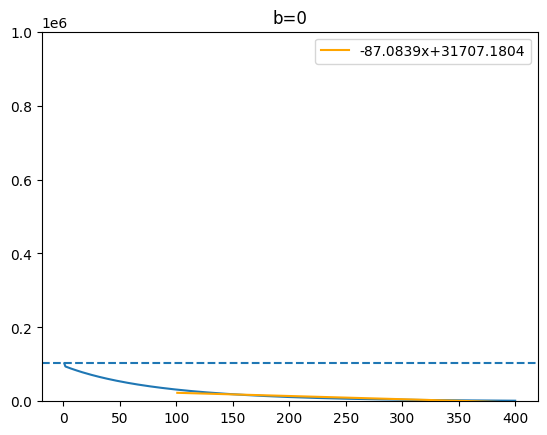

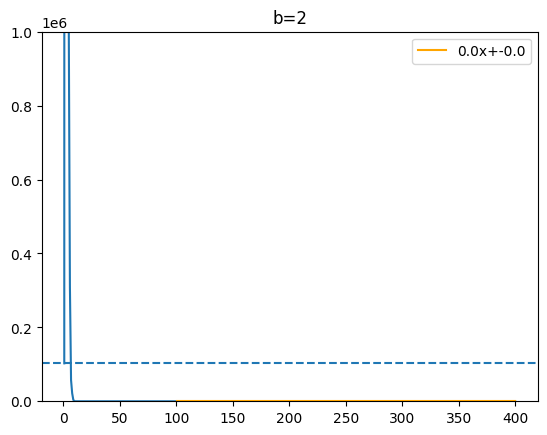

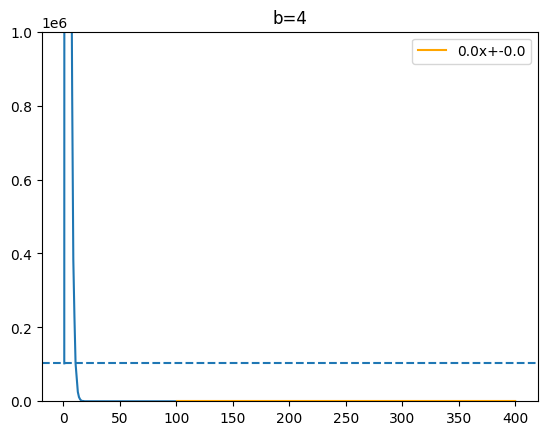

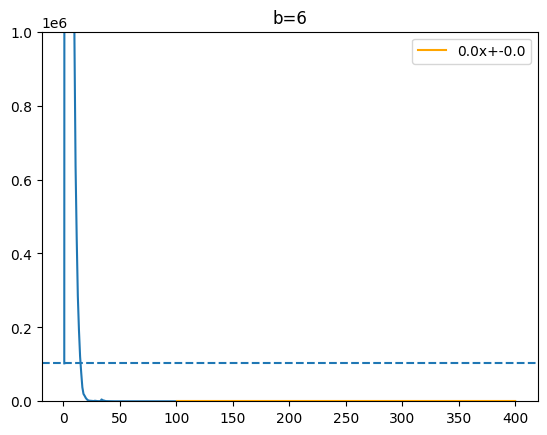

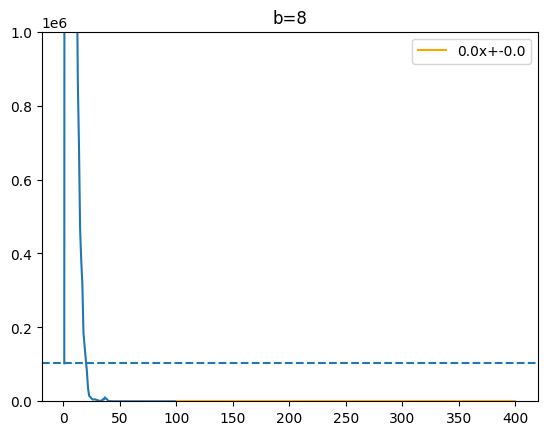

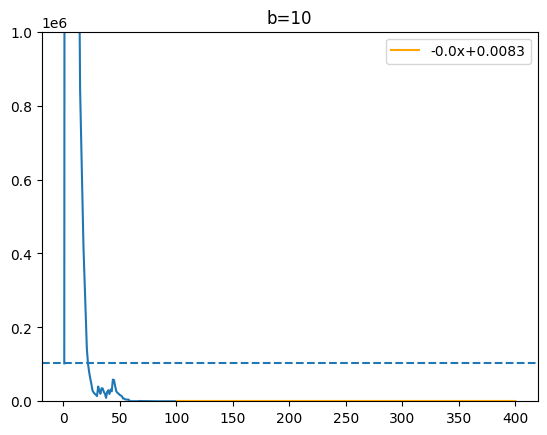

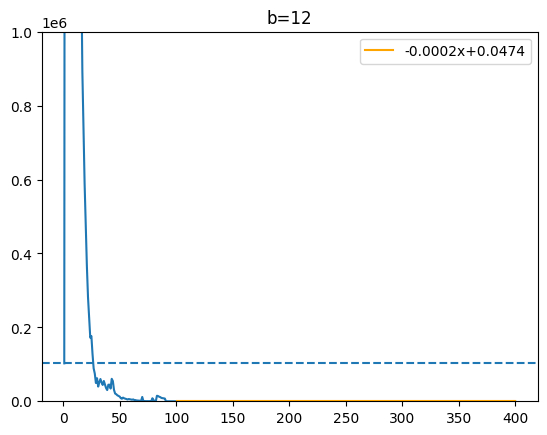

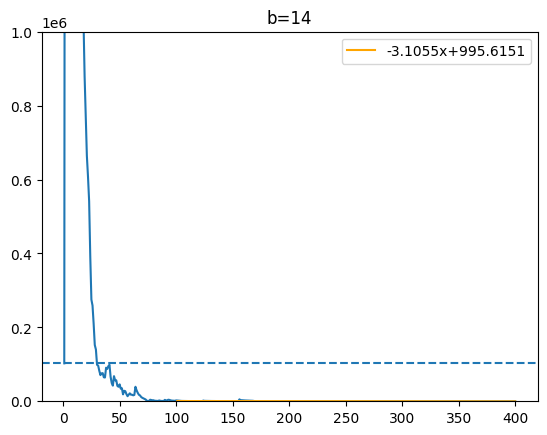

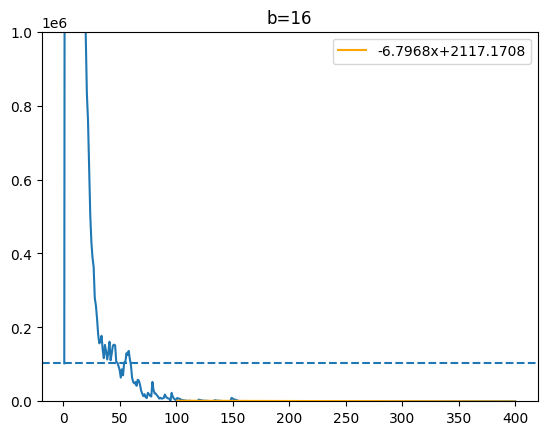

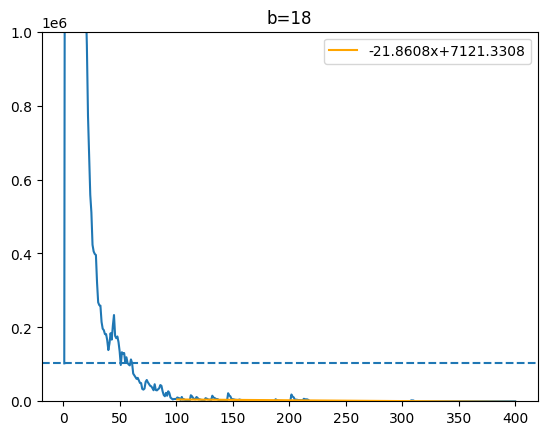

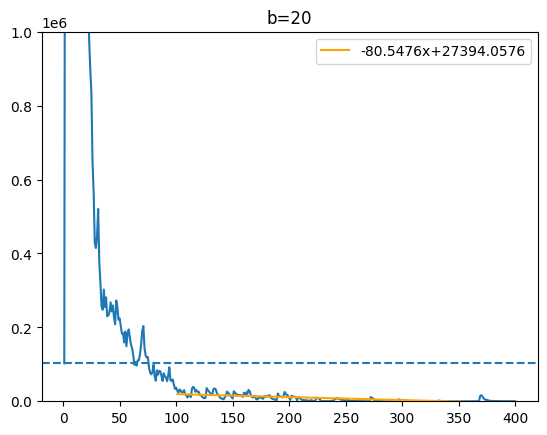

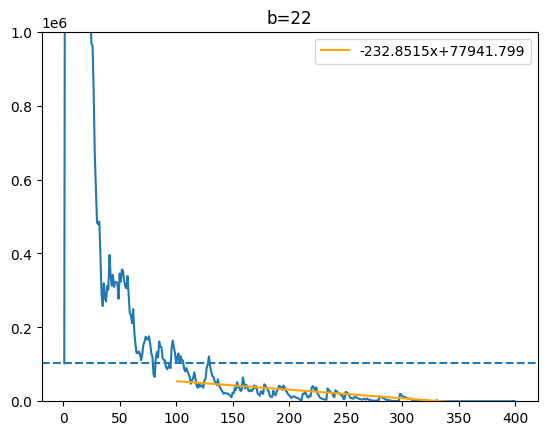

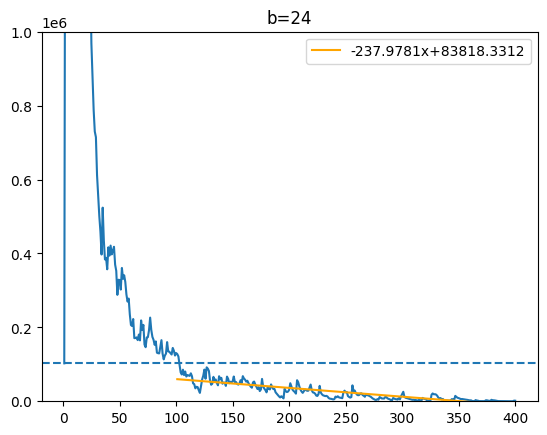

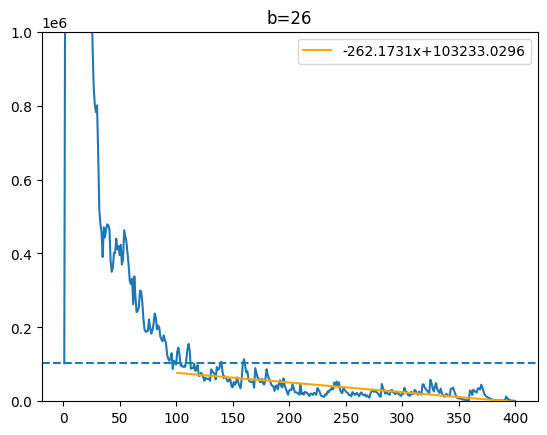

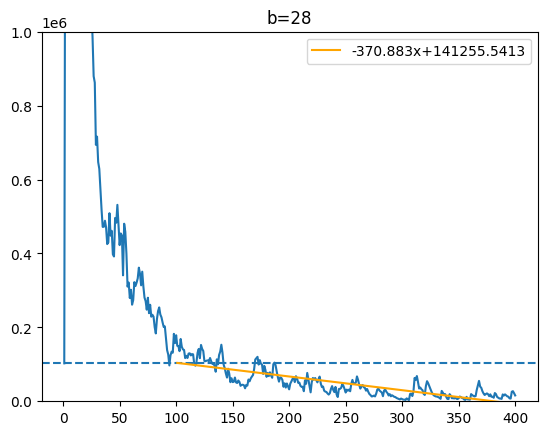

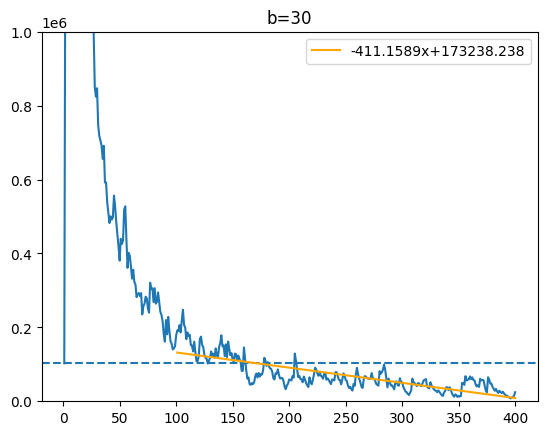

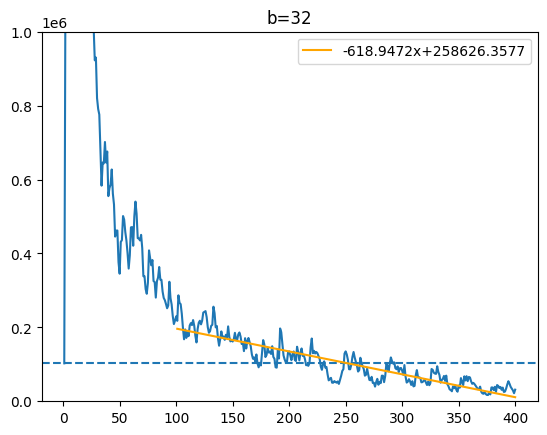

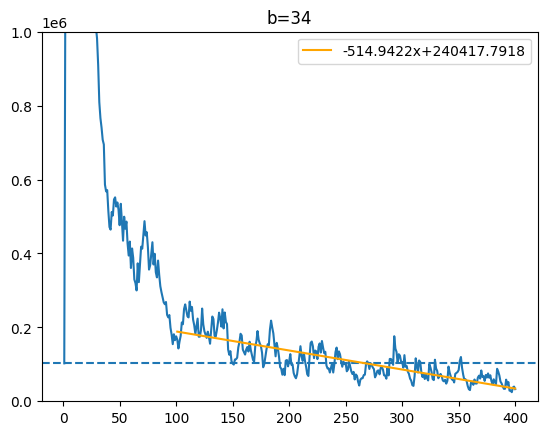

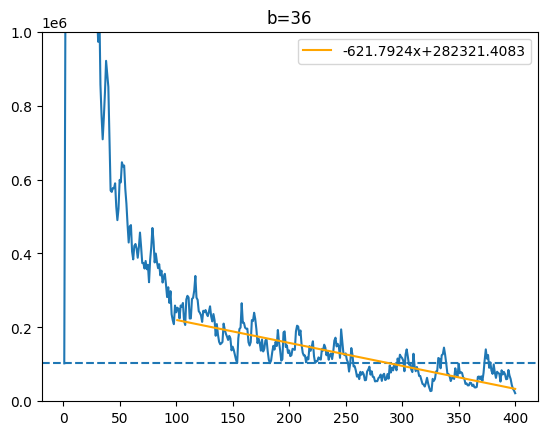

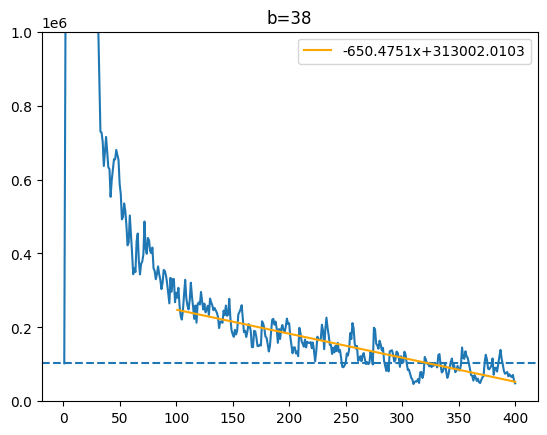

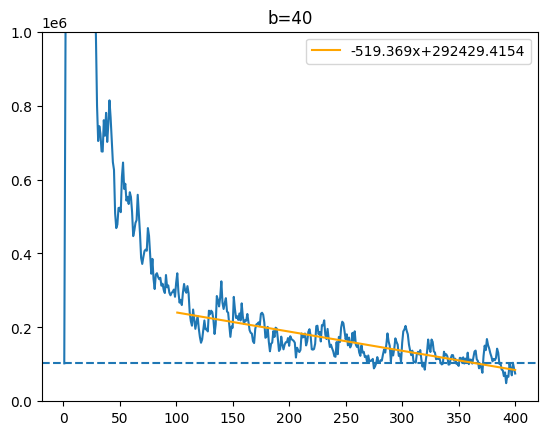

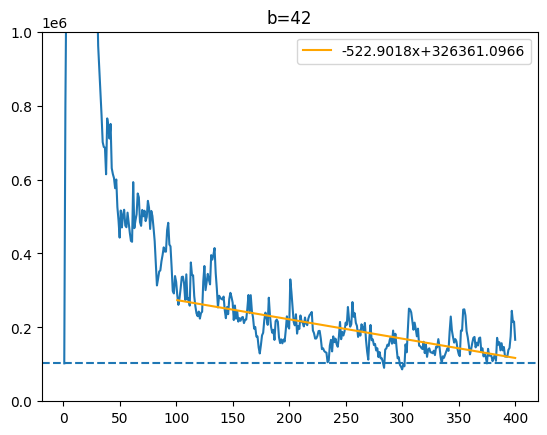

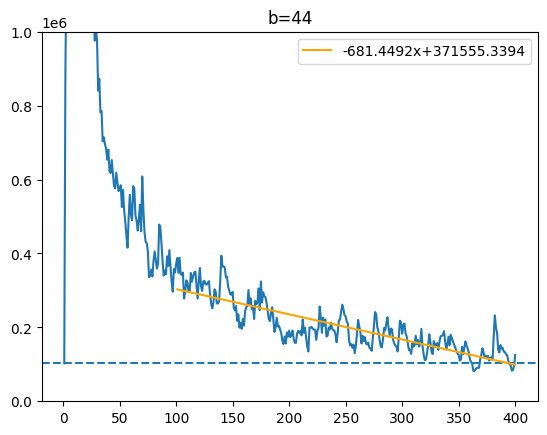

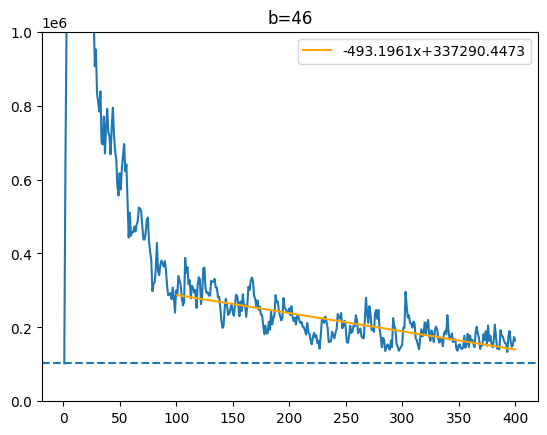

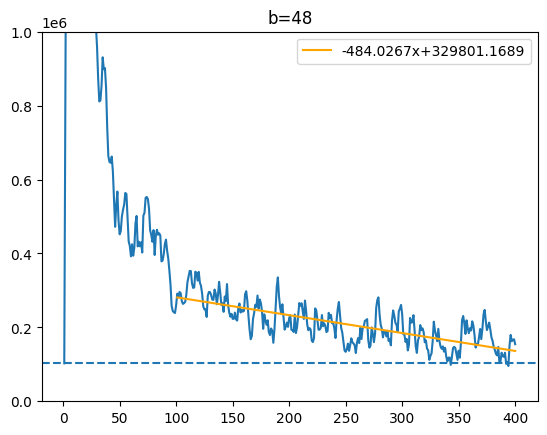

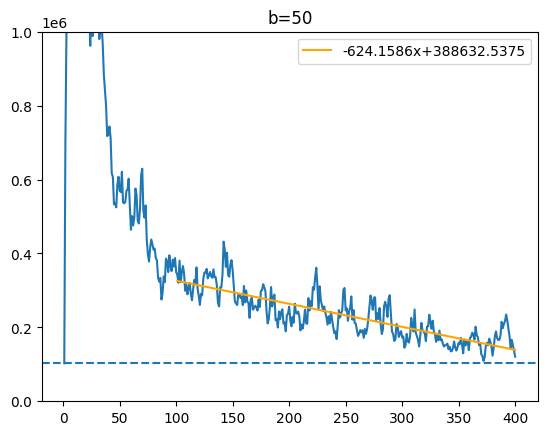

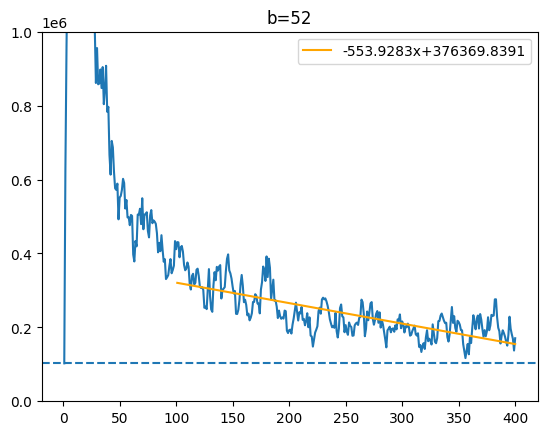

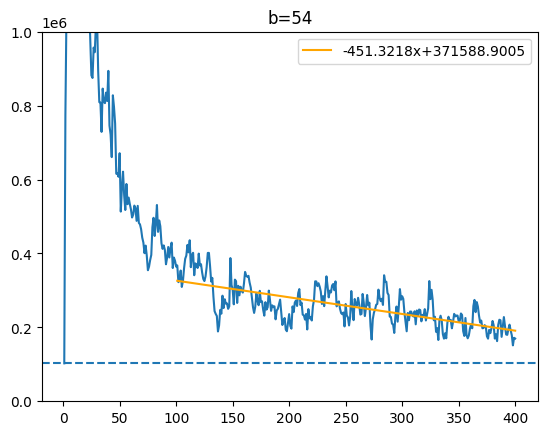

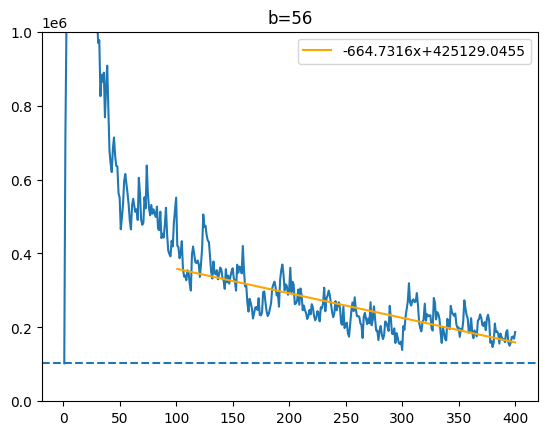

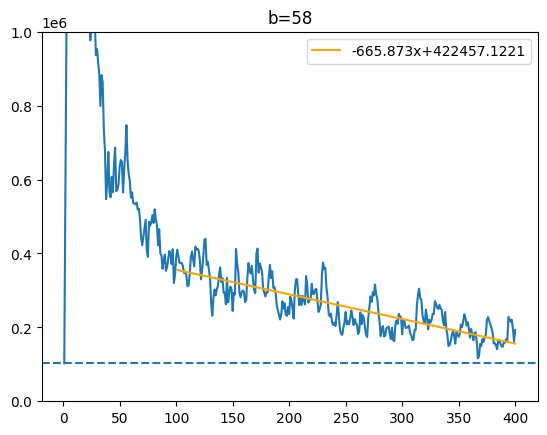

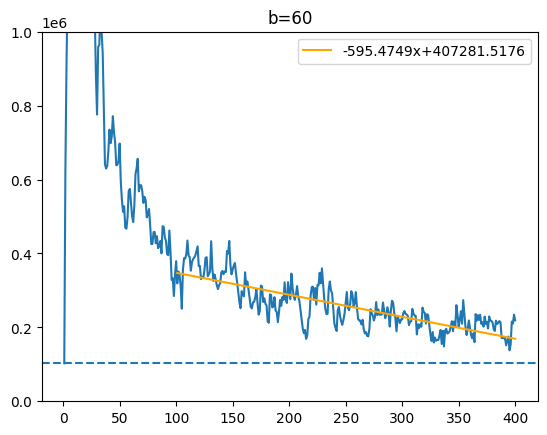

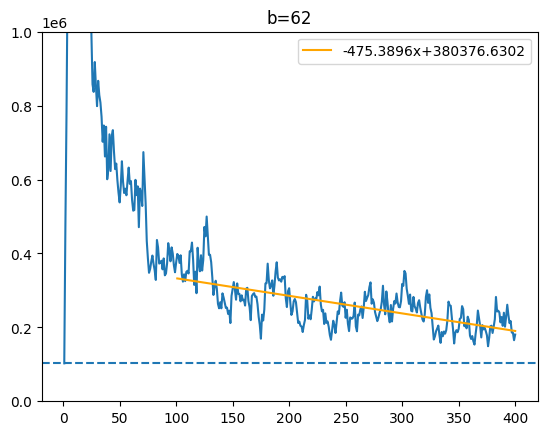

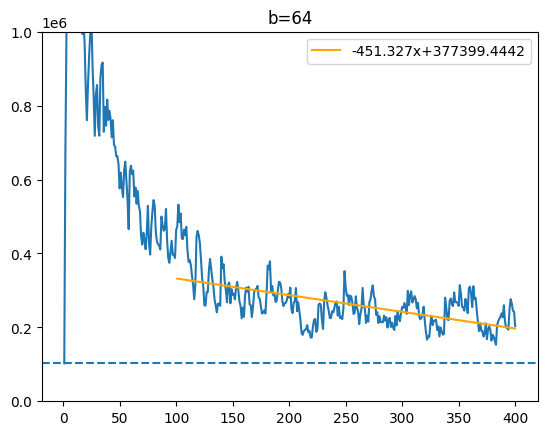

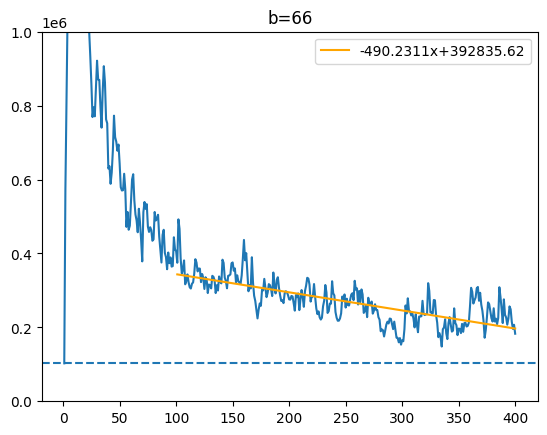

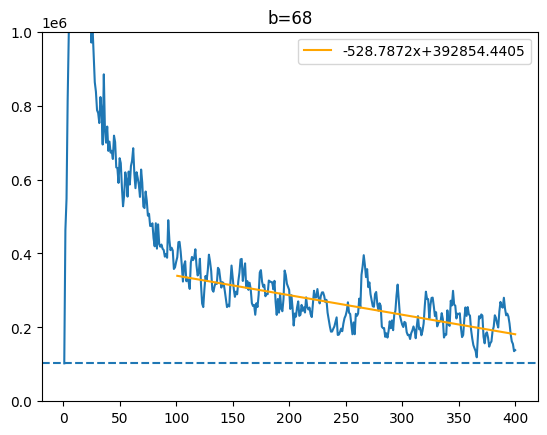

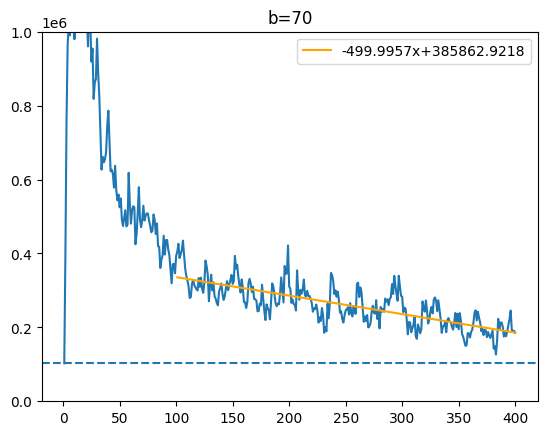

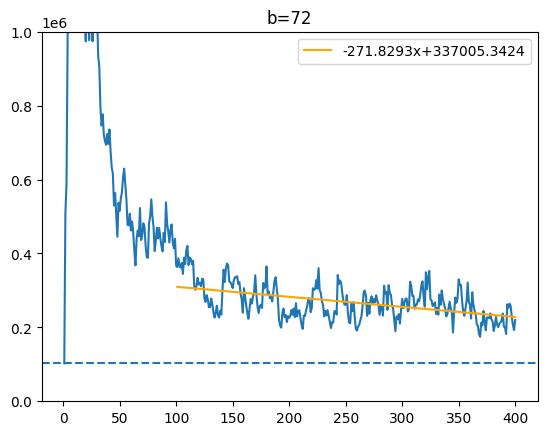

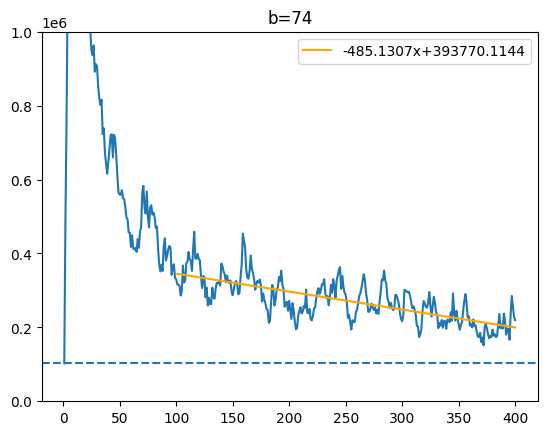

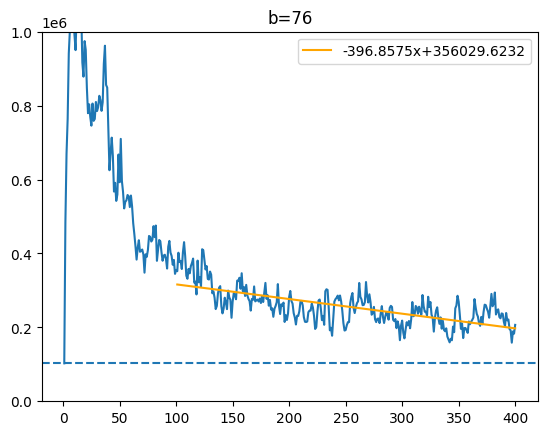

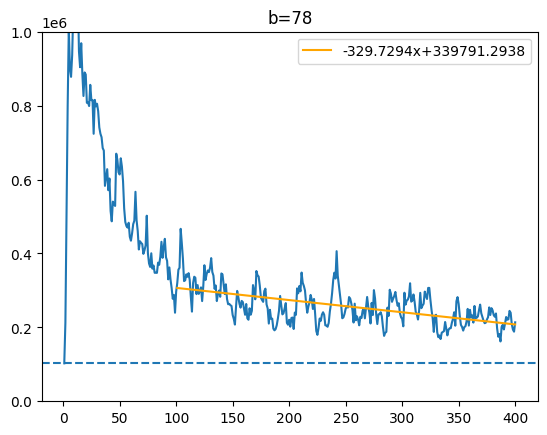

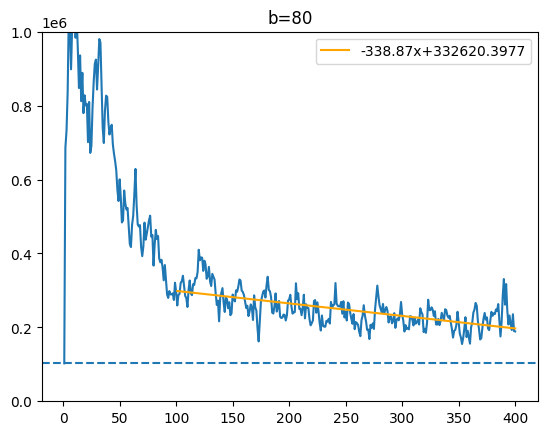

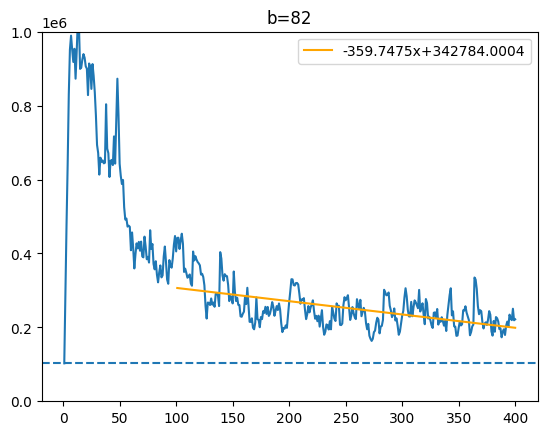

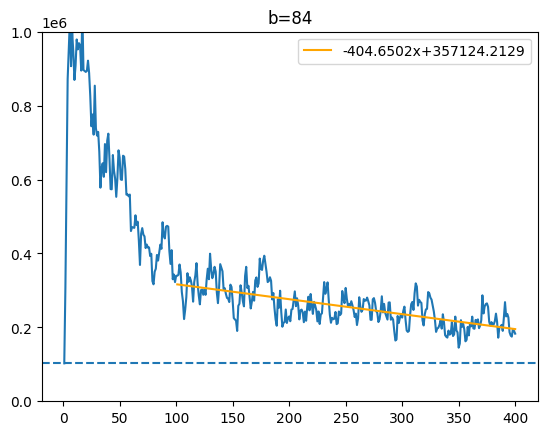

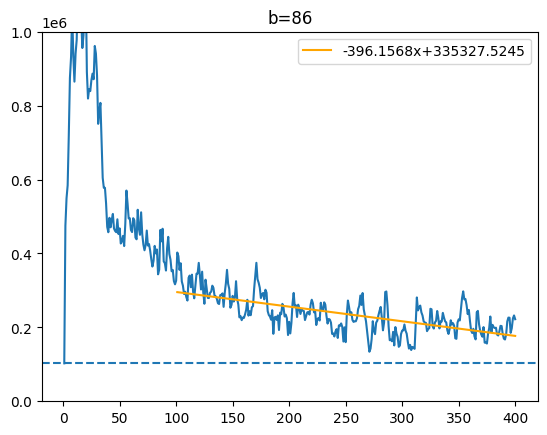

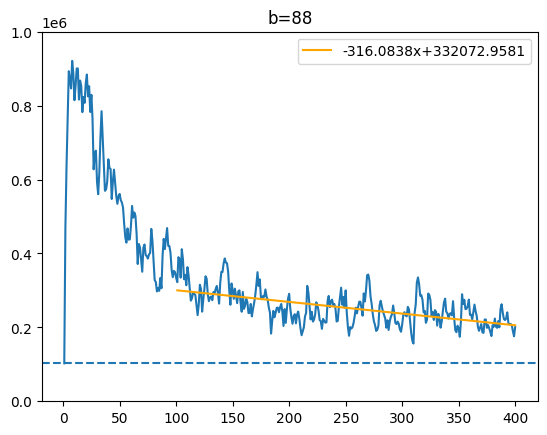

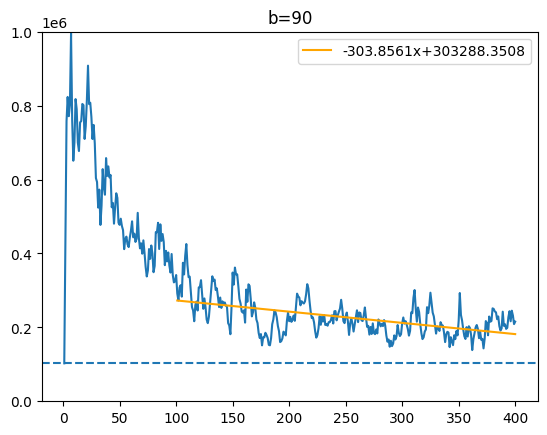

In [53]:
def line(x, m, b):
    return m*x + b

for job_i, job in enumerate(jobs):
    if job_i > 0: continue
    
    decay_rates = []
    for b in b_vec[0:]:
        with job.data as data:
            census_t = np.array(data["census_t"])
            N_tot_mean = np.array(data[f"N_tot_mean/{b}"])
        
        burn_in_end_i = 100
        final_i = len(N_tot_mean)
        
        x = census_t[burn_in_end_i:final_i]
        y = N_tot_mean[burn_in_end_i:final_i]
        popt, pcov = curve_fit(line, x, y)
        decay_rates.append(popt[0])
        plt.plot(x, line(x, *popt), label='{}x+{}'.format(np.round(popt[0], 4), np.round(popt[1], 4)), c='orange', zorder=3)
        
        # # Try smoothing
        # std_power = 2.0
        # std = np.std(N_tot_mean[-int(len(census_t)*0.25):])
        # s = len(x) * std**std_power
        # tck = splrep(x, y, s=s)
        # census_t_new = np.linspace(min(x),max(x),int(len(x)*1))
        # N_tot_mean_smoothed = BSpline(*tck)(census_t_new)
        # plt.plot(census_t_new, N_tot_mean_smoothed, c='g')
        # popt, pcov = curve_fit(line, census_t_new, N_tot_mean_smoothed)
        # plt.plot(x, line(x, *popt), label='{}x+{}'.format(np.round(popt[0], 4), np.round(popt[1], 4)), c='lightgreen')
       
        plt.plot(census_t, N_tot_mean)
        plt.axhline(Aeff*K_adult, ls='--')
        plt.ylim(0,1e6)
        plt.legend()
        plt.title(f"b={b}")
        plt.show()

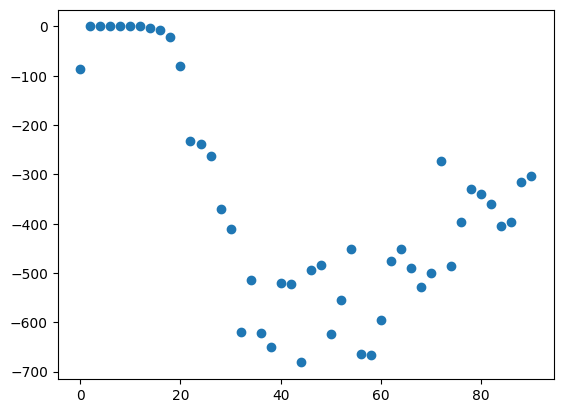

In [52]:
plt.scatter(b_vec, decay_rates)

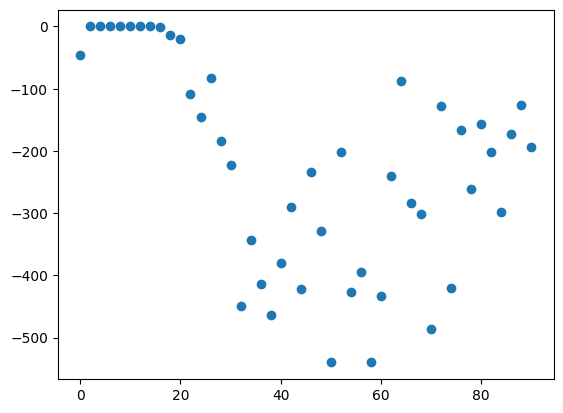

In [50]:
plt.scatter(b_vec, decay_rates)

## Manual

In [3]:
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
fri_vec = b_vec * gamma(1+1/c)

jobs = project.find_jobs({'doc.simulated': True, 'Aeff': Aeff, 't_final': t_final})
all_fri = np.tile(fri_vec, len(jobs))
fn = "aggregate_data/Aeff_{}/all_r_{}.npy".format(Aeff, t_final)
if not os.path.isfile(fn):
# if True:
    all_r = np.array([]) 
    for job_i, job in enumerate(jobs):
        with job.data as data:
            frac_change_vec = []
            for b in b_vec:
                frac_change_vec.append(float(data['fractional_change/{}'.format(b)]))
        all_r = np.append(all_r, frac_change_vec)
    if not os.path.isdir('aggregate_data'):
        os.makedirs('aggregate_data')
    with open(fn, 'wb') as handle:
        np.save(handle, all_r) 
else:
    with open(fn, 'rb') as handle:
        all_r = np.load(handle)
freq_bin_cntrs = np.load(f"aggregate_data/freq_bin_cntrs.npy")

### Expected val

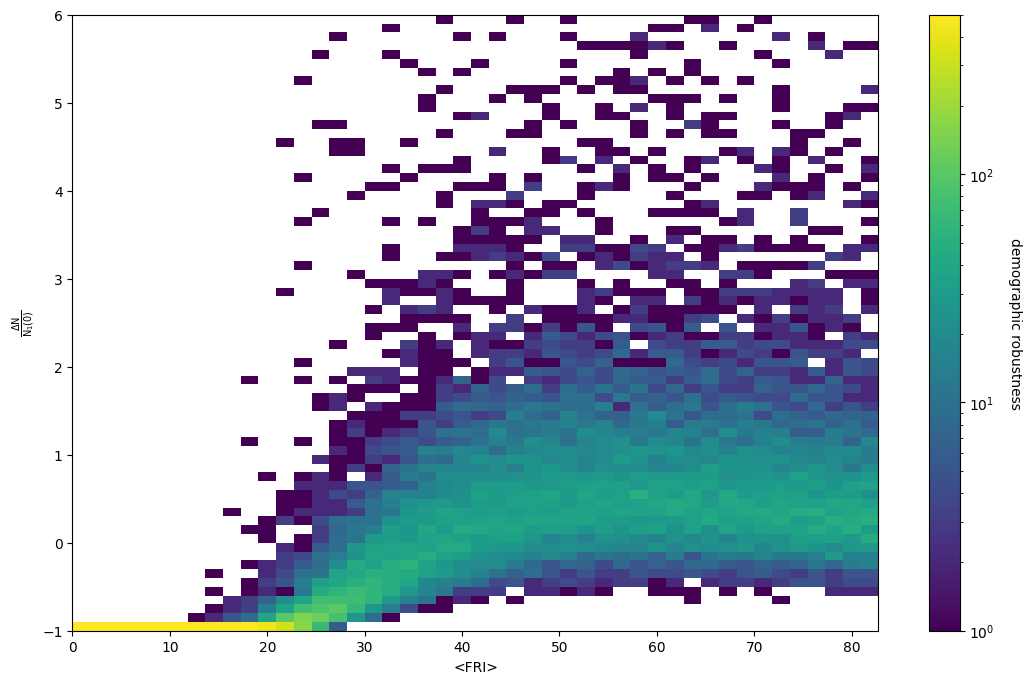

In [9]:
r_bw=0.1
r_edges = np.arange(-1, 6+r_bw, r_bw)
fri_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
fri_edges = np.concatenate(([0], np.arange(fri_step/2, fri_vec[-1]+fri_step, fri_step)))
fig, ax = plt.subplots(figsize=(13,8))
hist = ax.hist2d(all_fri, all_r, bins=[fri_edges, r_edges], 
                 norm=matplotlib.colors.LogNorm(vmax=int(len(all_r)/len(b_vec))))
cbar = ax.figure.colorbar(hist[-1], ax=ax, location="right")
cbar.ax.set_ylabel('demographic robustness', rotation=-90, fontsize=10, labelpad=20)
ax.set_xlabel('<FRI>')
ax.set_ylabel(r'$\frac{\Delta \text{N}}{\text{N}_1(0)}$')
if not os.path.isdir('figs/Aeff_{}'.format(Aeff)):
    os.makedirs('figs/Aeff_{}'.format(Aeff))
# fig.savefig('figs/Aeff_{}/sensitvity.png'.format(Aeff), bbox_inches='tight')

/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_36211/1786405572.py:25: RuntimeWarning: divide by zero encountered in divide
  b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)


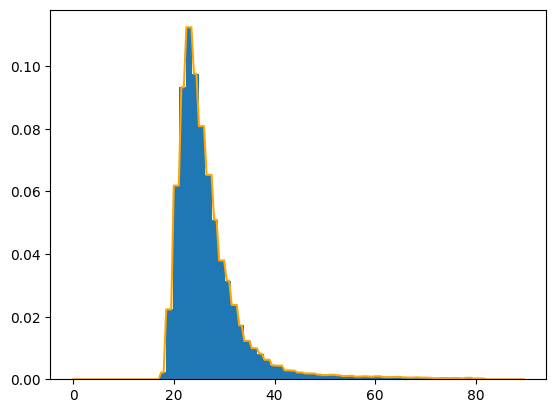

In [6]:
# Read in fixed fire map 
fdmfn = 'FDE_current_allregions.asc'
if fdmfn[-3:] == 'txt':
    fdm = np.loadtxt(fdmfn)
else:
    # Assume these are uncropped .asc maps
    ul_coord = [1500, 2800]
    lr_coord = [2723, 3905]
    usecols = np.arange(ul_coord[0],lr_coord[0])
    fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                             max_rows=lr_coord[1], usecols=usecols)
# Read in patchmap 
patchmapfn = 'frame0_patchmap.ASC'
patchmap = np.loadtxt(patchmapfn, skiprows=6)
def adjustmaps(maps):
    dim_len = []
    for dim in range(2):
        dim_len.append(min([m.shape[dim] for m in maps]))
    for mi, m in enumerate(maps):
        maps[mi] = m[0:dim_len[0], 0:dim_len[1]]
    return maps
patchmap, fdm = adjustmaps([patchmap, fdm])
delta_t = 30
c = 1.42
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
fri_raster = b_raster * gamma(1+1/c)
fri_sub = fri_raster[(patchmap > 0) & (fdm > 0)] # Why are there any zeros in FDM at all?
fri_flat = fri_sub.flatten()
fri_hist = plt.hist(fri_flat[fri_flat < max(fri_vec)], bins=50, density=True);
P_fri_x0 = scipy.stats.rv_histogram((fri_hist[0], fri_hist[1]))
x = np.arange(0,90,0.5)
plt.plot(x, P_fri_x0.pdf(x), color='orange')
# plt.hist(1 / fri_flat[fri_flat < max(fri_vec)], bins=50);
# plt.axvline(1/66, c='k')

In [11]:
min(sdm_flat)

0.32649827003479004

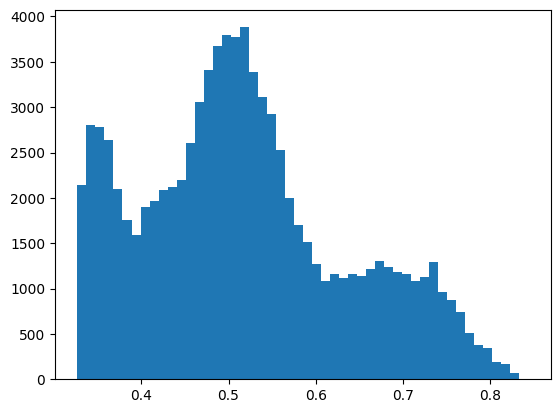

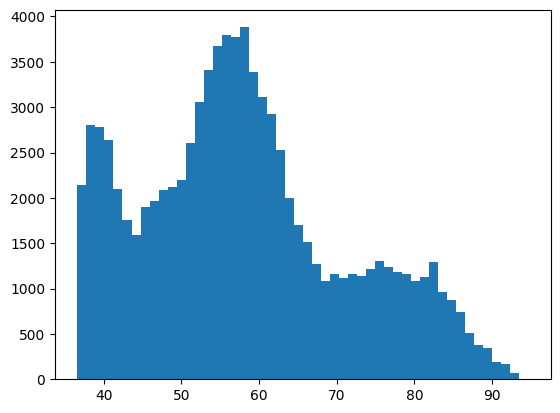

In [8]:
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
# plt.imshow(sdm)
# plt.show()
sdm_flat = sdm.flatten()[sdm.flatten() != 0]
plt.hist(sdm_flat, bins=50)
plt.show()

A_cell = (270**2)/10000
A_o = 0.1
h_o = 0.65 #just a guess
# otay = np.loadtxt("otayraster.asc", skiprows=6)
# sdm_otay = sdm[otay==1] #index "1" indicates the specific part where study was done
# h_o = np.mean(sdm_otay[sdm_otay!=0]) #excluding zero, would be better to use SDM w/o threshold
# # Histogram an estimate for the effective area relative to 'A=1' with adjustments for the on-site A and H
plt.hist((sdm_flat*A_cell)/(h_o*A_o), bins=50);

In [12]:
dfri = 0.01
dr = 0.01
r_vals = np.arange(min(hist[2]), max(hist[2])+dr, dr)
r_expect = 0
for fri_i in range(len(hist[0])):
    P_r_fri = scipy.stats.rv_histogram((hist[0][fri_i], hist[2]))
    r_expect_fri = np.trapz(y=P_r_fri.pdf(r_vals)*r_vals, x=r_vals)
    fri_vals = np.arange(fri_edges[fri_i], fri_edges[fri_i+1], dfri)
    # This is a bad approximation, where I assume P_r_fri does not change within this fri bin
    # using for now because I sampled uniformly in b for each demo sample
    # rerun data with random sampling in b?
    P_dfri = np.trapz(y=P_fri_x0.pdf(fri_vals), x=fri_vals)
    r_expect += r_expect_fri * P_dfri
r_expect_baseline = r_expect

In [13]:
# A few constants (more hardcoded below)
max_fri = 66
A_cell = 270**2 / 1e6 #km^2
dr = 0.01
dfri = 0.01
with open("../model_fitting/mortality/map.json", "r") as handle:
    mort_params = json.load(handle)
K_adult = mort_params['K_adult']

# Flatten then sort fire frequency and habitat suitability data
fri_flat = fri_sub.flatten()
fire_freqs = 1 / fri_flat[fri_flat < max(fri_vec)] #ignore fri above what we simulated, only a small amount
freq_argsort = np.argsort(fire_freqs)
fire_freqs_sorted = fire_freqs[freq_argsort]
sdm_sub = sdm[(patchmap > 0) & (fdm > 0)]
sdm_flat = sdm_sub.flatten()
sdm_flat = sdm_flat[fri_flat < max(fri_vec)]
sdm_sorted = sdm_flat[freq_argsort]

# Get bins of initial fire frequency for phase data
slice_left_min = np.nonzero(fire_freqs_sorted > (1/max_fri))[0][0]
freq_range = fire_freqs_sorted[-1] - fire_freqs_sorted[slice_left_min]
freq_bw = freq_range/20
freq_bin_edges = np.arange(fire_freqs_sorted[slice_left_min], fire_freqs_sorted[-1], freq_bw)
freq_bin_cntrs = np.array([edge+freq_bw/2 for edge in freq_bin_edges]) #should read this in

# Loop over different resource constraint values
# baseline_areas = np.arange(0.02, 0.53, 0.03) #km
baseline_areas = np.array([5, 10]) #km

## Saved

In [19]:
test = [[1,2]]
test.append(np.array([4,5,6]))
test

[[1, 2], array([4, 5, 6])]

/Users/patrick/miniconda3/envs/sbi_env/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


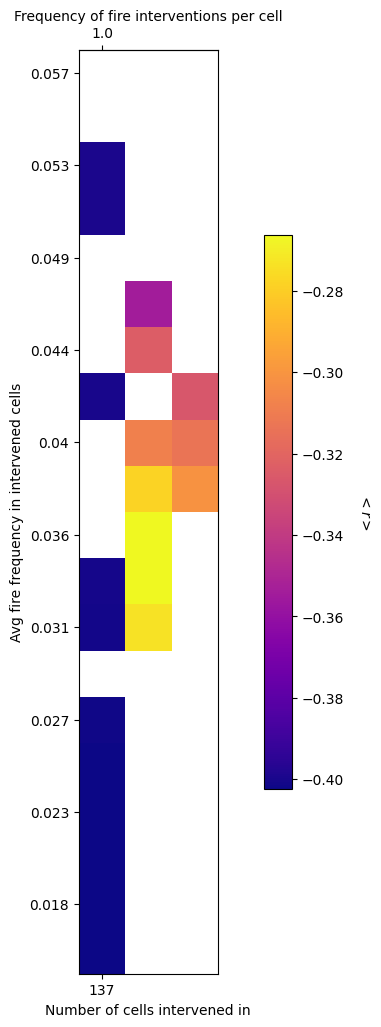

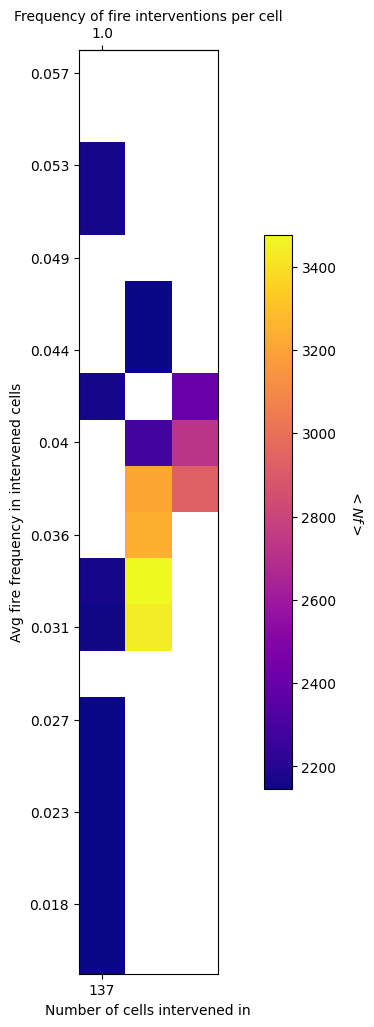

In [22]:
for baseline_area in baseline_areas:
    n_cell_baseline = round(baseline_area/A_cell)
    constraint = n_cell_baseline * fif_baseline
    n_cell_vec = np.load(f"aggregate_data/Aeff_{Aeff}/n_cell_vec_{constraint}.npy")
    fif_vec = np.array([constraint/n_cell for n_cell in n_cell_vec])
    for metric in ['r', 'Nf']:
        fn = "phase_mats/Aeff_{}/phase_{}_{}_{}.npy".format(Aeff, metric, round(constraint), t_final)
        if not os.path.isfile(fn): continue
        phase_space = np.load(fn)
        phase_space = np.ma.masked_where(phase_space==0, phase_space)
        fn = f"aggregate_data/Aeff_{Aeff}/{metric}_expect_nochange_{t_final}.json"
        with open(fn, 'r') as handle:
            metric_baseline = json.load(handle)
            metric_baseline = metric_baseline["{}_expect_nochange".format(metric)]
        fig, ax = plt.subplots(figsize=(12,12))
        phase_flat = phase_space.flatten()
        cmap = copy.copy(matplotlib.cm.plasma)
        '''doing this for now bc some runs are bad'''
        if metric=='r':
            phase_max = np.quantile(phase_flat[phase_flat != np.ma.masked], 0.98)
            # phase_max = 0.11
        if metric=='Nf':
            phase_max = max(phase_flat[phase_flat != np.ma.masked])
        cmap.set_bad('white')
        # cmap.set_over('k')
        im = ax.imshow(phase_space, norm=matplotlib.colors.Normalize(vmin=metric_baseline, vmax=phase_max), cmap=cmap)
        cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
        cbar.ax.set_ylabel(r'$<{}>$'.format(metric), rotation=-90, fontsize=10, labelpad=20)
        ytick_spacing = 2
        ytick_labels = np.flip(freq_bin_cntrs)[::ytick_spacing]
        yticks = np.arange(0,len(freq_bin_cntrs),ytick_spacing)
        ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
        ax.set_ylabel('Avg fire frequency in intervened cells')
        xtick_spacing = 3
        xticks = np.arange(0,len(n_cell_vec),xtick_spacing)
        ax.set_xticks(xticks, labels=n_cell_vec[::xtick_spacing]);
        ax.set_xlabel('Number of cells intervened in')
        secax = ax.secondary_xaxis('top')
        secax.set_xticks(xticks, labels=np.round(fif_vec[::xtick_spacing], decimals=3));
        secax.set_xlabel('Frequency of fire interventions per cell')
        fig.savefig('figs/Aeff_{}/phase_{}_{}.png'.format(Aeff,metric,round(constraint)), bbox_inches='tight')

Text(0, 0.5, '<r>')

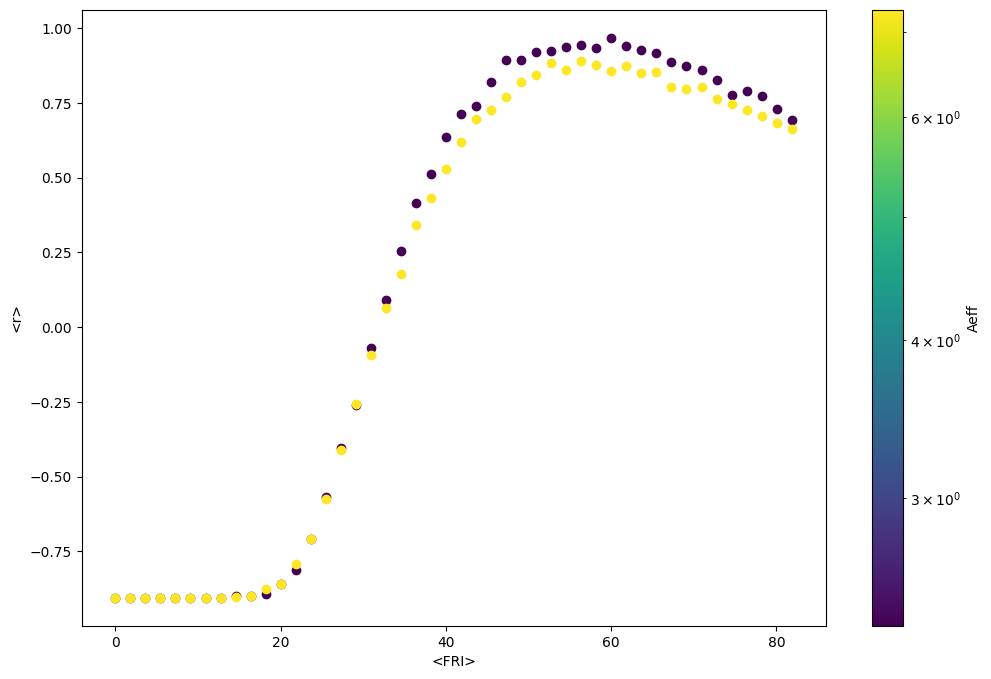

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
# A_vec = np.array([1,0.5,5,10,100])
Aeff_vec = np.array([2.38, 7.29])
# norm = matplotlib.colors.Normalize(vmin=min(A_vec), vmax=20, clip=True)
norm = matplotlib.colors.LogNorm(vmin=min(A_vec), vmax=max(A_vec), clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.viridis)
for Aeff in Aeff_vec:
    jobs = project.find_jobs({'doc.simulated': True, 'Aeff': Aeff, 't_final': t_final})
    # numreps = 2_000 if A == 1 else 1_000
    all_fri = np.tile(fri_vec, len(jobs))
    fn = "aggregate_data/Aeff_{}/all_r_{}.npy".format(Aeff, t_final)
    with open(fn, 'rb') as handle:
        all_r = np.load(handle)
    r_bw=0.1
    r_edges = np.arange(-1, 6+r_bw, r_bw)
    fri_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
    fri_edges = np.concatenate(([0], np.arange(fri_step/2, fri_vec[-1]+fri_step, fri_step)))
    hist = np.histogram2d(all_fri, all_r, bins=[fri_edges, r_edges])
    dr = 0.01
    r_vals = np.arange(min(hist[2]), max(hist[2])+dr, dr)
    r_expect = 0
    r_expect_vec = []
    for fri_i in range(len(hist[0])):
        P_r_fri = scipy.stats.rv_histogram((hist[0][fri_i], hist[2]))
        r_expect_fri = np.trapz(y=P_r_fri.pdf(r_vals)*r_vals, x=r_vals)
        r_expect_vec.append(r_expect_fri)
    color = mapper.to_rgba(Aeff)
    ax.scatter(fri_vec, r_expect_vec, color=color)
    # break
fig.colorbar(mapper, ax=ax, label='Aeff')
ax.set_xlabel('<FRI>')
ax.set_ylabel('<r>')

## Test nint runs

In [55]:
from scipy.interpolate import splrep, BSpline
N_tot_mean_disc = np.load("nint_data/N_tot_mean_discrete.npy")
N_tot_mean_nint = np.load("nint_data/N_tot_mean_nint.npy")

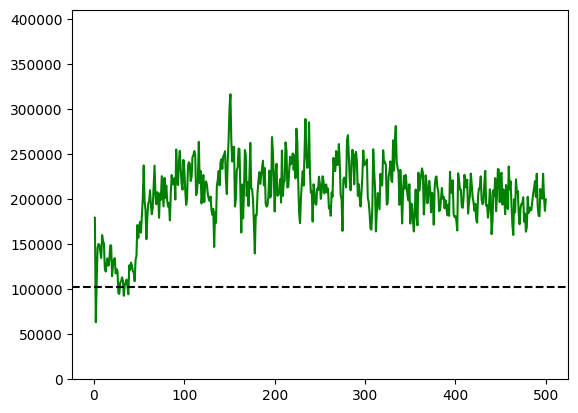

In [56]:
t_vec = np.arange(1,len(N_tot_mean_nint)+1)
# plt.plot(t_vec, N_tot_mean_disc, c='k')
plt.plot(t_vec, N_tot_mean_nint, c='g')
plt.ylim(0,K_adult*Aeff*4)
# plt.ylim(0,K_adult*Aeff*12)
plt.axhline(K_adult*Aeff, ls='--', c='k')
plt.show()

In [57]:
t_fire_vec = np.load("nint_data/t_fire_vec.npy")

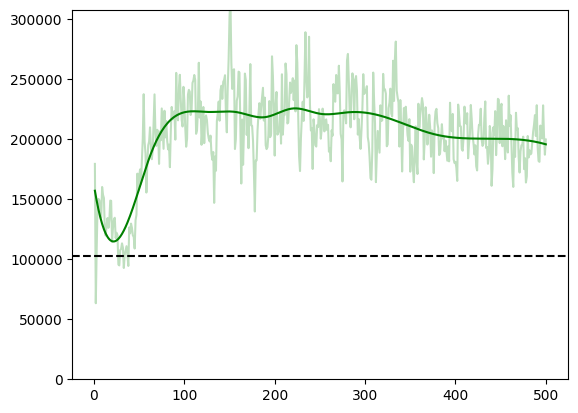

In [62]:
std_power = 2.06

# disc_std = np.std(N_tot_mean_disc[-int(len(t_vec)*0.25):])
# s_disc = len(t_vec) * disc_std**std_power
# disc_tck = splrep(t_vec, N_tot_mean_disc, s=s_disc)

nint_std = np.std(N_tot_mean_nint[-int(len(t_vec)*0.25):])
s_nint = len(t_vec) * nint_std**std_power
nint_tck = splrep(t_vec, N_tot_mean_nint, s=s_nint)#s=len(t_vec)*1e10)

t_vec_new = np.linspace(1,max(t_vec),int(len(t_vec)*1))
# plt.plot(t_vec, N_tot_mean_disc, c='k', alpha=0.25)
# plt.plot(t_vec_new, BSpline(*disc_tck)(t_vec_new), c='k')
plt.plot(t_vec, N_tot_mean_nint, c='g', alpha=0.25)
plt.plot(t_vec_new, BSpline(*nint_tck)(t_vec_new), c='g')
# plt.ylim(0.9*K_adult*Aeff,K_adult*Aeff*2)
plt.ylim(0,K_adult*Aeff*3)
plt.axhline(K_adult*Aeff, ls='--', c='k')

In [10]:
job.sp.params

{'alph_m': 0.20511598885059357, 'beta_m': 0.26941290497779846, 'sigm_m': 0.9133228063583374, 'gamm_nu': 0.2661186456680298, 'kappa': 1.0596392154693604, 'rho_max': 111.13227844238281, 'eta_rho': 0.79925137758255, 'a_mature': 27.195171356201172, 'sigm_max': 0.5648550987243652, 'eta_sigm': 0.22584758698940277, 'gamm_m': 0.01, 'tau_m': 0.01, 'mu_m': 0.0, 'alph_nu': 0.0, 'beta_nu': 0.25, 'K_seedling': 84482.5935949838, 'K_adult': 14080.432265830634}

## Debugging nint

In [6]:
from model import Model
# # Read in map parameters
# params = {}
# for pr in ['mortality', 'fecundity']:
#     with open('../model_fitting/{}/map.json'.format(pr), 'r') as handle:
#         params.update(json.load(handle))
# Use job params
params = job.sp.params

Aeff = 7.29 #2.38
#fri = 40
c = 1.42
b = 40#fri / gamma(1+1/c)
t_final = 400
# Get the average habitat suitability within the Otay Mtn Wilderness area
sdmfn = "SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6)
otay = np.loadtxt("otayraster.asc", skiprows=6)
sdm_otay = sdm[otay==1] #index "1" indicates the specific part where study was done
h_o = np.mean(sdm_otay[sdm_otay!=0]) #excluding zero, would be better to use SDM w/o threshold
A_o = 0.1 #area of observed sites in Ha
delta_t = 1
num_reps = 1_000
N_0_1 = Aeff*params['K_adult']
N_0_1_vec = np.repeat(N_0_1, num_reps)
init_age = round(params['a_mature']) + 20
t_vec = np.arange(delta_t, t_final+delta_t, delta_t)

cond = False
while not cond:
    model = Model(**params)
    model.set_effective_area(Aeff)
    model.init_N(N_0_1_vec, init_age)
    model.set_t_vec(t_vec)
    model.set_weibull_fire(b=b, c=c)
    # Generate vector of fire occurances
    model.generate_fires()
    t_fire_vec = model.t_fire_vec
    model.simulate(method="nint", census_every=1, progress=True)
    N_tot_mean_nint = model.N_tot_vec.mean(axis=0)
    cond = (N_tot_mean_nint[-1] / np.mean(N_tot_mean_nint[-20:])) > 4

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/Volumes/External/Research/Regan/TecateCypress/sensitivity/model.py:197: RuntimeWarning: overflow encountered in exp
  dens_dep = ((nu_t)*(1-m_t)) / (1 + np.exp(-eta_t*self.K_adult*(N/K_t - self.Aeff)))
 16%|██████▎                                | 161/1000 [00:00<00:05, 161.20it/s]


KeyboardInterrupt: 

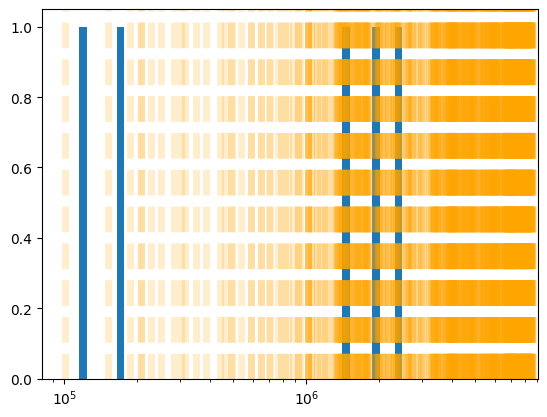

In [7]:
# upper_lim = K_adult*1e100
# upper_lim = 1e7
upper_lim = 1e1000
lower_lim = 1e5
binfrac = 0.4

final_abundances = model.N_tot_vec[:,-1]
filt = (final_abundances>lower_lim) & (final_abundances<upper_lim)
# filt = (final_abundances>100000)
fab_binnum = int(sum(filt)*binfrac)
# hist = plt.hist((final_abundances[filt]), bins=fab_binnum);
# bins=np.logspace(np.log10(1e5),np.log10(0.5e9), 50)
binnum = 50
binsize = np.log10(max(final_abundances)) / binnum
bins=np.logspace(np.log10(lower_lim),np.log10(max(final_abundances))+binsize, binnum)
hist = plt.hist((final_abundances[filt]), bins=bins);
plt.xscale('log')

for i in range(2,400):
    prior_abundances = model.N_tot_vec[:,-i]
    plt.axvline(max(prior_abundances), ls='--', c='orange', alpha=0.2, lw=5)
    # filt = (prior_abundances>lower_lim) & (prior_abundances<upper_lim)
    # pab_binnum = int(sum(filt)*binfrac)
    # filt = (final_abundances>100000)
    # hist = plt.hist((prior_abundances[filt]), bins=pab_binnum, color='orange');
    # hist = plt.hist((prior_abundances[filt]), bins=fab_binnum, color='orange');

In [122]:
final_excess = final_abundances[final_abundances > max(prior_abundances)] - max(prior_abundances)
sum(final_excess)
within_prior = final_abundances[(final_abundances <= max(prior_abundances))]
np.mean(within_prior)
N_tot_mean_nint[-2]

425219191.03008413

In [23]:
# N_tot_filtered = model.N_tot_vec[model.N_tot_vec[:,-1] > 1e7]
# N_tot_filtered = model.N_tot_vec[(model.N_tot_vec[:,-1] > 0.1e7) & (model.N_tot_vec[:,-1] < 10e7)]
# filt = (model.N_tot_vec[:,-1] > 0.01e7) & (model.N_tot_vec[:,-1] < 1e7)
filt = (model.N_tot_vec[:,-1] < 1e7)
N_tot_filtered = model.N_tot_vec[filt]

In [24]:
N_tot_filtered.shape

(161, 400)

(350.0, 401.0)

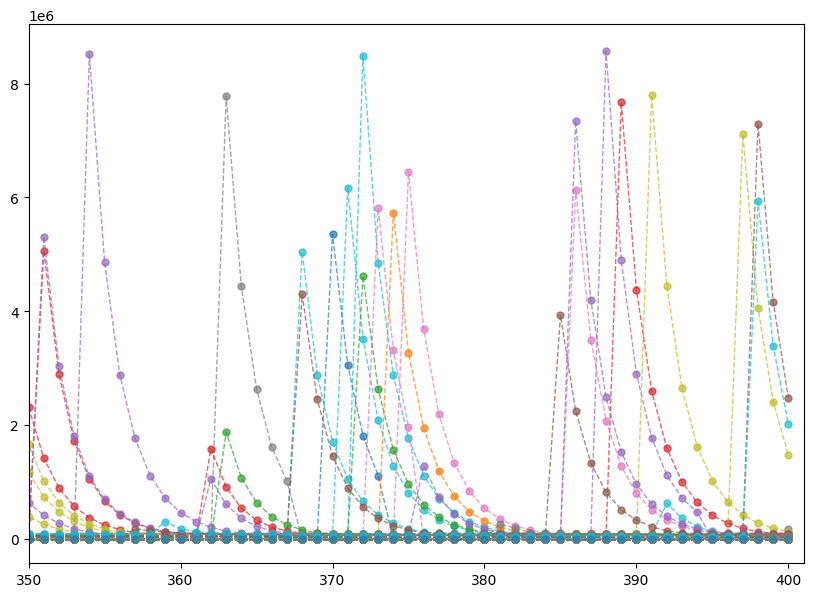

In [27]:
plt.figure(figsize=(10,7))
for N_tot in N_tot_filtered:
    if N_tot[-1] < 1e7:
        ls = '--'
    else:
        ls = '-'
    plt.plot(model.census_t, N_tot, ls=ls, marker='o', markersize=5, lw=1, alpha=0.7)
    # plt.plot(model.census_t, N_tot, ls=ls, marker)
# plt.yscale('log')
# plt.ylim(1e-100,1e10)
# plt.ylim(-1e2, 1e7)
# plt.ylim(-1e2, 1e2)
plt.xlim(350,401)

In [30]:
job.id

'fe918612c0f865d2fb578f0e6c1c5644'

In [28]:
model.simulate(method="discrete", census_every=1, progress=True)
N_tot_mean_disc = model.N_tot_vec.mean(axis=0)

  1%|▍                                          | 4/399 [00:00<00:25, 15.53it/s]/Volumes/External/Research/Regan/TecateCypress/sensitivity/model.py:162: RuntimeWarning: overflow encountered in exp
  dens_dep = ((nu_a[age_i])*(1-m_a[age_i])) / (1 + np.exp(-eta_a[age_i]*self.K_adult*(N/K_a[age_i] - self.Aeff)))
100%|█████████████████████████████████████████| 399/399 [00:20<00:00, 19.77it/s]


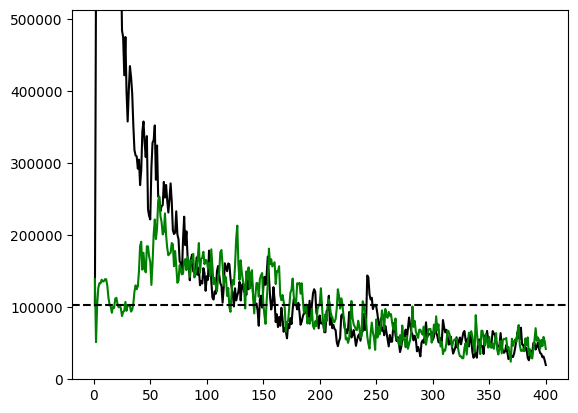

In [29]:
t_vec = np.arange(1,len(N_tot_mean_nint)+1)
plt.plot(t_vec, N_tot_mean_disc, c='k')
plt.plot(t_vec, N_tot_mean_nint, c='g')
# plt.scatter(t_vec, N_tot_mean_nint, c='g', s=1)
plt.ylim(0,K_adult*Aeff*5)
# plt.ylim(0,K_adult*Aeff*12)
plt.axhline(K_adult*Aeff, ls='--', c='k')
plt.show()

## Robustness

In [3]:
fri_vec = b_vec * gamma(1+1/c)
fri_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
bw = 0.2
bin_edges = np.arange(-1, 6+bw, bw)
metric_labels = ['bin_robustness']
metric_data = {lab: [[] for _bin in range(len(bin_edges))] for lab in metric_labels}
jobs = project.find_jobs({'doc.simulated': True})
# for job in project.find_jobs({'doc.simulated': True}):
for job in jobs:
    r_vec = np.ones(len(b_vec))*np.nan
    with job.data as data:
        for b_i, b in enumerate(b_vec):
            r_vec[b_i] = float(data['fractional_change/{}'.format(b)])
    for bin_i, left in enumerate(bin_edges):
        within = np.nonzero((r_vec >= left) & (r_vec < left+bw))[0]
        # within = np.nonzero(r_vec >= left)[0]
        bin_robustness = len(within) * fri_step
        metric_data['bin_robustness'][bin_i].append(bin_robustness)


KeyboardInterrupt



In [ ]:
metric = 'bin_robustness'
demo_samples = len(jobs)

In [ ]:
metric_max = max([max(data) for data in metric_data[metric]])

In [ ]:
r_bin_cntrs = [np.mean(bin_edges[i:i+2]) for i in range(len(bin_edges)-1)]
r_bin_cntrs = np.array([np.round(v, decimals=1) for v in r_bin_cntrs])

In [ ]:
metric_bw = 4
# metric_min = 1 / demo_samples
metric_min = fri_step
metric_bin_edges = np.concatenate(([0,metric_min], np.arange(metric_bw, metric_max+metric_bw, metric_bw)))
metric_bin_cntrs = np.array([np.round(np.mean(metric_bin_edges[i:i+2]), decimals=2) for i in range(len(metric_bin_edges)-1)])
res_mat = np.zeros((len(metric_bin_cntrs), len(bin_edges)))

In [ ]:
for r_bin_i, r_left in enumerate(bin_edges):
    # print('response',r_left)
    for metric_bin_i, metric_left in enumerate(metric_bin_edges[:-1]):
        metric_right = metric_bin_edges[metric_bin_i+1]
        # print('metric',metric_left, metric_right)
        within = np.nonzero((metric_data[metric][r_bin_i] >= metric_left) & (metric_data[metric][r_bin_i] < metric_right))[0]
        # print(within)
        demo_count = len(within) / demo_samples
        # res_mat[len(metric_bin_edges)-1-metric_bin_i][r_bin_i] = demo_count
        res_mat[len(metric_bin_cntrs)-1-metric_bin_i][r_bin_i] = demo_count

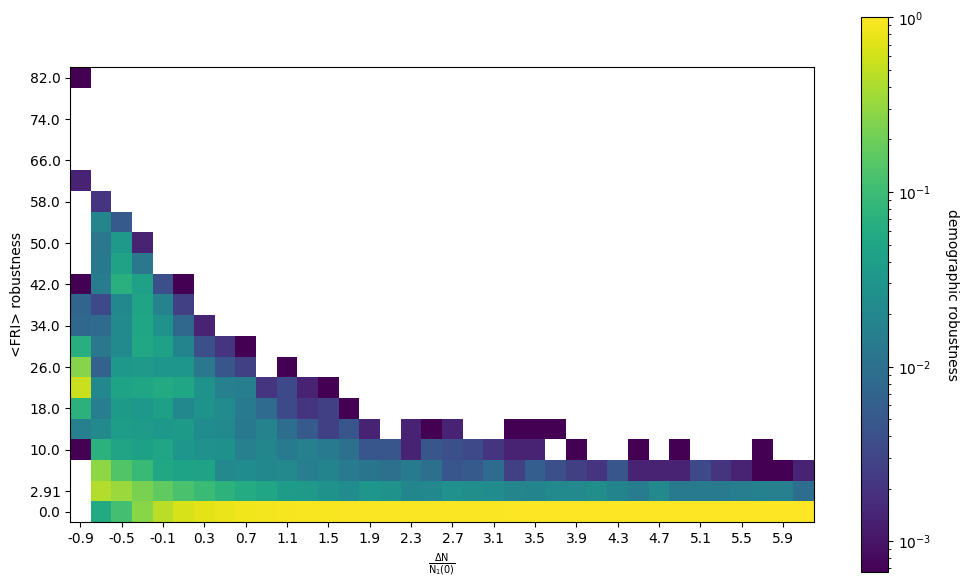

In [9]:
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(res_mat, norm=matplotlib.colors.LogNorm(vmax=1))
# im = ax.imshow(res_mat, norm=matplotlib.colors.Normalize(vmax=0.3))
# im = ax.imshow(res_mat[10:][:])
cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
cbar.ax.set_ylabel('demographic robustness', rotation=-90, fontsize=10, labelpad=20)
ytick_spacing = 2
ytick_labels = np.flip(metric_bin_cntrs)[::ytick_spacing]
ytick_labels = np.append(ytick_labels, 0)
yticks = np.arange(0,len(metric_bin_cntrs),ytick_spacing)
yticks = np.append(yticks, len(metric_bin_cntrs)-1)
ax.set_yticks(yticks, labels=ytick_labels);
ax.set_ylabel('<FRI> robustness')
ax.set_xticks(np.arange(0,len(r_bin_cntrs),2), labels=r_bin_cntrs[::2]);
ax.set_xlabel(r'$\frac{\Delta \text{N}}{\text{N}_1(0)}$')
# ax.set_xticks(np.arange(0,len(bin_edges),2), labels=[np.round(v, decimals=2) for v in bin_edges[::2]]);
# ax.set_xlabel(r'$\frac{\Delta \text{N}}{\text{N}_1(0)}$ threshold')
# ax.set_ylim(0,10)
fig.savefig('robustness.png', bbox_inches='tight')